# Kaggle Histopathology

This notebook is a fast.ai implementation for the Kaggle challenge [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection)

## Setup and Data Viz

In [61]:
#hide
#magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [128]:
#collapse-hide
#imports
from utils import read, subplot, get_learner, auc_score

import sys
sys.setrecursionlimit(100000)
import glob

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from torchvision import transforms
from fastai.vision import *
from fastai.metrics import *

In [63]:
#collapse-show
dataPath = Path('data/')
train = dataPath/'train'
test = dataPath/'test'

In [64]:
data = pd.read_csv(dataPath/'train_labels.csv')
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
id       220025 non-null object
label    220025 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


There are two columns in the data, one which represents the filename in the train directory. The second column shows the corresponding label for the said image

In [66]:
data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

We're dealing with an imbalanced dataset here. There's roughly 1.5x as many positive images as negative ones. We'll need to correct that before we start training. 

Let's look at some sample images

In [67]:
pos = data[data['label'] == 1]
neg = data[data['label'] == 0]

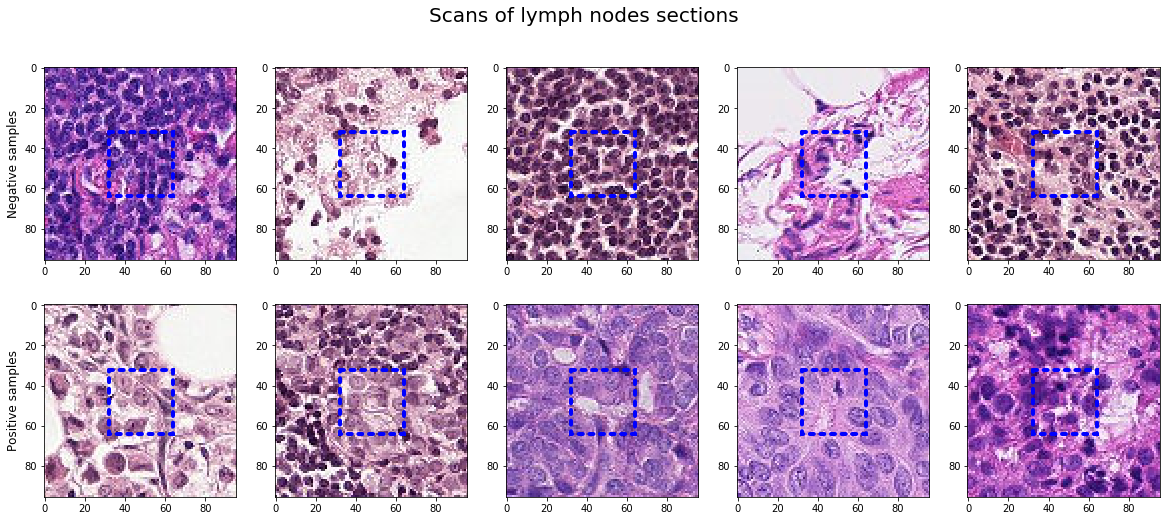

In [68]:
subplot(train, shuffle(pos), shuffle(neg))

## Data Split and DataBlock API

In [69]:
p_val = 0.2

In [70]:
train_files = data['id'].values
train_labels = np.asarray(data['label'].values)

_, _, _, val_idx = train_test_split(train_files, \
                                                range(len(train_files)), \
                                                test_size = p_val, \
                                                stratify = train_labels, \
                                                random_state = 42)

In [71]:
train_model_dict = {
    'names' : train_files,
    'label': train_labels
}

In [72]:
test_files = []
test_names = list(test.rglob('*.tif'))
for idx, name in enumerate(test_names):
    test_files.append(str(name).split('/')[-1])

In [73]:
train_df = pd.DataFrame(data = train_model_dict)
test_df = pd.DataFrame(np.asarray(test_files), columns = ['name'])

In [74]:
tfms = get_transforms()

In [75]:
dataBunch = (ImageList.from_df(path = train, df = train_df, suffix = '.tif')
             .split_by_idx(val_idx)
             .label_from_df(cols = 'label')
             .add_test(ImageList.from_df(path = test, df = test_df))
             .transform(tfms = tfms, size = 90) #default fast.ai transforms
             .databunch(bs = 64)
             ## datasets stats obtained from https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai 
             .normalize([tensor([0.702447, 0.546243, 0.696453]), tensor([0.238893, 0.282094, 0.216251])]))

In [76]:
assert dataBunch.c == 2
assert dataBunch.classes == [0,1]

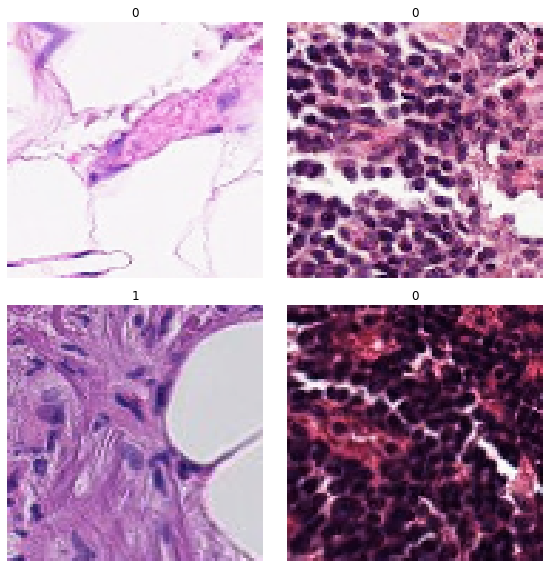

In [77]:
dataBunch.show_batch(2)

## fast.ai Model with Pretrained CNNs

In [78]:
archs = [models.densenet169, models.resnet50, models.resnet18]
learners = [None] * len(archs)

assert len(archs) == len(learners)

for idx, arch in enumerate(archs):
    learners[idx] = get_learner(dataBunch, arch, metrics = ['accuracy', 'auc_score'])

In [ ]:
# densenet = deepcopy(learners[0])
# resnet50 = deepcopy(learners[1])
# resnet18  = deepcopy(learners[2])t

## DenseNet169


In [79]:
densenet = learners[0]

epoch,train_loss,valid_loss,accuracy,time
0,0.224359,0.171506,0.936235,12:44


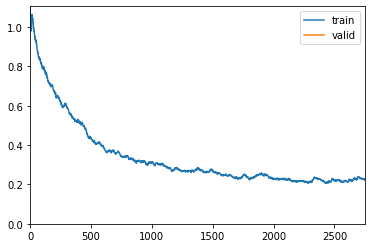

In [42]:
densenet.fit_one_cycle(1, max_lr = 8e-4, wd = 5e-7)

epoch,train_loss,valid_loss,accuracy,time
0,0.228560,0.154844,0.943529,12:48
1,0.173968,0.142278,0.947847,12:47


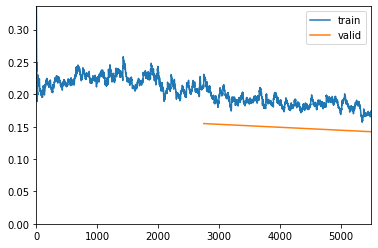

In [47]:
densenet.fit_one_cycle(2)

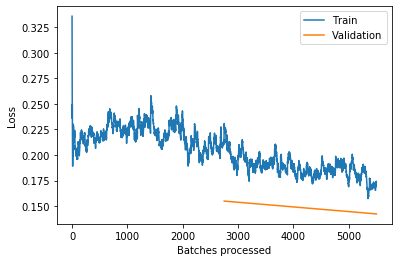

In [48]:
densenet.recorder.plot_losses()

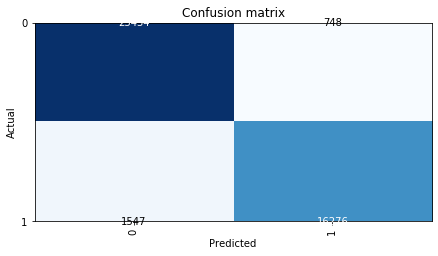

In [50]:
interpret = ClassificationInterpretation.from_learner(densenet)
interpret.plot_confusion_matrix('Confusion Matrix')

In [162]:
#save model before further experimentation
densenet.save('densenet169' + '_m1'')

In [80]:
densenet.load('densenet169_m1')

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90)
y: CategoryList
0,1,0,0,0
Path: data/train;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90)
y: CategoryList
0,0,0,0,0
Path: data/train;

Test: LabelList (57458 items)
x: ImageList
Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90)
y: EmptyLabelList
,,,,
Path: data/train, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer

In [81]:
densenet.unfreeze()
densenet.lr_find(wd = 1e-4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


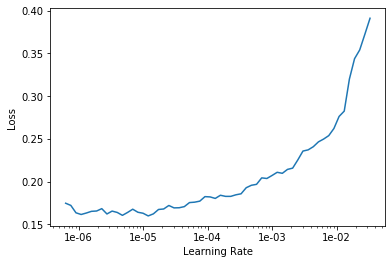

In [82]:
densenet.recorder.plot()

In [ ]:
densenet.callback_fns.append(partial(SaveModel, monitor='accuracy'))

epoch,train_loss,valid_loss,accuracy,time
0,0.184088,0.138469,0.949369,14:35
1,0.165618,0.133470,0.951392,14:36
2,0.156897,0.126377,0.954232,14:41
3,0.141486,0.115355,0.958687,14:39
4,0.127796,0.112109,0.959164,14:35
5,0.120753,0.105985,0.961754,14:34
6,0.108366,0.102412,0.963459,14:43
7,0.106546,0.099049,0.964936,14:40
8,0.103396,0.097982,0.965368,14:42
9,0.101522,0.099048,0.964436,14:43


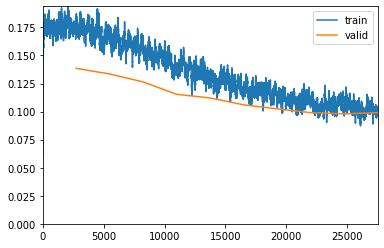

In [83]:
densenet.fit_one_cycle(10, max_lr = slice(5e-6, 5e-5))

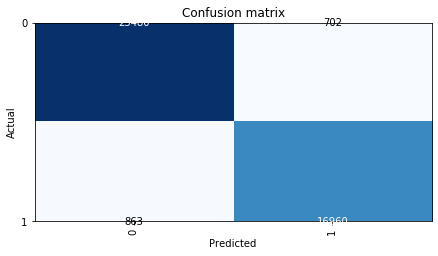

In [156]:
interpret = ClassificationInterpretation.from_learner(densenet)
interpret.plot_confusion_matrix()

This looks like the right moment to stop training. We can see that the validation and training loss are converging, but if we were to continue training for more cycles, there's a good chance the validation loss would start to go up(especially considering it was increasing for the final iteration). And that's when the model would start overfitting, and we definitely don't want that. Let's save this model and go on evaluating the model and visualizing the GradCAM heatmaps

In [86]:
densenet.save('densenet169' + '_m2')

## ROC Curve and AUC Score

In [151]:
#Load the best performing model
densetnet.load('densenet169_m2')
preds,y = densenet.get_preds()

In [152]:
ros_auc_score = auc_score(preds,y)
print('The ROC AUC Score is {0}'.format(ros_auc_score))

acc = accuracy(preds,y)
print('The accuracy is {0}%.'.format(acc*100))

The ROC AUC Score is 0.9929073272062267
The accuracy is 96.44358825683594%.


## Submit submissions.csv to Kaggle

In [153]:
clean_fname = np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fname_cleaned = clean_fname(dataBunch.test_ds.items)
fname_cleaned = fname_cleaned.astype(str)

In [154]:
pt,yt = densenet.get_preds(ds_type=DatasetType.Test)

In [155]:
sub = pd.read_csv(dataPath/'sample_submission.csv')
submission_df = sub.set_index('id')

submission_df.loc[fname_cleaned,'label'] = to_np(pt[:,1])
submission_df.to_csv(f'submission.csv')

In [161]:
!kaggle competitions submit histopathologic-cancer-detection -f submission.csv -m "fast.ai densenet169"

100%|██████████████████████████████████████| 2.88M/2.88M [00:02<00:00, 1.03MB/s]
Successfully submitted to Histopathologic Cancer Detection